# Module 4 - Explore the Graph

This module has the following objectives:
1. Running Cypher queries to better understand the data
2. Deduplicating definitions that are very similar
3. Use GDS to find useful patterns in the Graph

Import our usual suspects (and some more...)

In [2]:
import os
import pandas as pd
from dotenv import load_dotenv
from graphdatascience import GraphDataScience
from neo4j import Query, GraphDatabase, RoutingControl, Result
from openai import OpenAI
import matplotlib.pyplot as plt
import seaborn as sns

/home/martijn/.cache/pypoetry/virtualenvs/rabobank-workshop-genai-DPgl1B5U-py3.12/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


# Setup

Load env variables

In [3]:
env_file = 'credentials.env'

In [4]:
if os.path.exists(env_file):
    load_dotenv(env_file, override=True)

    # Neo4j
    HOST = os.getenv('NEO4J_URI')
    USERNAME = os.getenv('NEO4J_USERNAME')
    PASSWORD = os.getenv('NEO4J_PASSWORD')
    DATABASE = os.getenv('NEO4J_DATABASE')

    # AI
    OPENAI_API_KEY = os.getenv('OPENAI_API_KEY')
    os.environ['OPENAI_API_KEY']=OPENAI_API_KEY
    LLM = os.getenv('LLM')
    EMBEDDINGS_MODEL = os.getenv('EMBEDDINGS_MODEL')
else:
    print(f"File {env_file} not found.")

Connect to neo4j db

In [5]:
driver = GraphDatabase.driver(
    HOST,
    auth=(USERNAME, PASSWORD)
)

In case we want to split large files

In [6]:
def split_dataframe(df, chunk_size = 50_000):
    chunks = list()
    num_chunks = len(df) // chunk_size + 1
    for i in range(num_chunks):
        chunks.append(df[i*chunk_size:(i+1)*chunk_size])
    return chunks

Test the connection

In [7]:
driver.execute_query(
    """
    MATCH (n) RETURN COUNT(n) as Count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,Count
0,1419


## Explore the graph 

Now to the database and observe what is there. Example queries:

- `MATCH (n:Customer) RETURN n LIMIT 25`

- `MATCH (n:Chunk) RETURN n LIMIT 25`

- `MATCH p=()-[r:PART_OF]->() RETURN p LIMIT 25`

We can also run this via the [Neo4j Python Driver](https://neo4j.com/docs/python-manual/5/) wihtin your Notebook. Let's do so below!

### How many Customers are there in the graph?

In [8]:
driver.execute_query(
    """
    MATCH (cust:Customer) 
    RETURN COUNT(cust)
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,COUNT(cust)
0,50


### What products do customers have? 

In [9]:
customer_product_df = driver.execute_query(
    """
    MATCH (cust:Customer)-[:HAS_PRODUCT]->(prod:Product)
    WITH DISTINCT cust, COLLECT(prod.name) AS products
    RETURN cust.name AS customer_name, SIZE(products) AS num_products, products LIMIT 10
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [10]:
customer_product_df

,customer_name,num_products,products
0,Lucas Vos,1,[SpaarRekening Product]
1,Rik Meijer,1,[RaboBusiness Banking Product]
2,Sara Bakker,2,"[DirectRekening Product, SpaarRekening Product]"
3,Jan Smit,3,"[BeleggersRekening Product, Kortlopende Reis P..."
4,Jan De Vries,1,[BeleggersRekening Product]
5,Henk De Vries,1,[DirectRekening Product]
6,Eva Bos,2,"[RaboBusiness Banking Product, Kortlopende Rei..."
7,Jan Smit,3,"[RaboBusiness Banking Product, BeleggersRekeni..."
8,Lars Vos,2,"[BeleggersRekening Product, Kortlopende Reis P..."
9,Bram Smit,2,"[SpaarRekening Product, BeleggersRekening Prod..."


### How many products on average?

In [11]:
customer_product_df["num_products"].describe()

count    10.000000
mean      1.800000
std       0.788811
min       1.000000
25%       1.000000
50%       2.000000
75%       2.000000
max       3.000000
Name: num_products, dtype: float64

### What are the most common products?

In [12]:
product_df = driver.execute_query(
    """
    MATCH (cust:Customer)-[:HAS_PRODUCT]->(prod:Product)
    RETURN DISTINCT prod.name AS product_name, COUNT(cust) AS num_customers ORDER BY num_customers DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [13]:
product_df

,product_name,num_customers
0,Kortlopende Reis Product,22
1,SpaarRekening Product,21
2,DirectRekening Product,18
3,BeleggersRekening Product,18
4,RaboBusiness Banking Product,14


### What documents are in the database?

In [14]:
document_df = driver.execute_query(
    """
    MATCH (prod_type:ProductType)<-[:RELATED_TO]-(doc:Document) 
    RETURN DISTINCT prod_type.name AS product_type, doc.file_name AS document, doc.pages AS num_pages
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [15]:
document_df

,product_type,document,num_pages
0,Kortlopende Reis,Interpolis Short-Term Travel Insurance.pdf,22
1,SpaarRekening,Rabo SpaarRekening 2020.pdf,14
2,RaboBusiness Banking,Terms & Conditions for Online Business Service...,29
3,DirectRekening,Payment and Online Services Terms Sept 2022.pdf,80
4,BeleggersRekening,Rabo Beleggersrekening Terms 2020.pdf,25


### How many chunks are the documents split into?

In [16]:
document_chunks_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)
    WITH DISTINCT doc, COLLECT(chunk) AS chunks
    RETURN doc.file_name AS file_name, doc.pages AS pages, SIZE(chunks) AS chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [17]:
document_chunks_df

,file_name,pages,chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,22,46
1,Rabo SpaarRekening 2020.pdf,14,44
2,Terms & Conditions for Online Business Service...,29,88
3,Payment and Online Services Terms Sept 2022.pdf,80,354
4,Rabo Beleggersrekening Terms 2020.pdf,25,78


---

## Extracted Definitions

Let's dive into the extracted definitions. 

Some definitions are **very similar** to each other or are **occurring in many documents and chunks**. Let's analyse this and see if we can find solutions to deal with these points!

In [18]:
definitions_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, COLLECT(def) AS definitions
    RETURN doc.file_name AS file_name, SIZE(definitions) AS definition_count, [def in definitions | def.term][0] AS definition_example, [def in definitions | def.description][0] AS description_example
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [19]:
definitions_df

,file_name,definition_count,definition_example,description_example
0,Interpolis Short-Term Travel Insurance.pdf,451,terms and conditions,The rules and guidelines that may be changed i...
1,Rabo SpaarRekening 2020.pdf,570,rabo,Savings Account 2020
2,Terms & Conditions for Online Business Service...,980,online service,Services that allow you to conduct (banking) b...
3,Payment and Online Services Terms Sept 2022.pdf,4523,payment,Any payment transaction resulting from the pay...
4,Rabo Beleggersrekening Terms 2020.pdf,1050,rabo,Savings Account 2020


### What definitions are mentioned most frequently within chunks?

Some definitions are mentioned in many chunks. These "supernodes" are often not informative as they do not capture specific information about the particular chunk itself.

In [20]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [21]:
definition_count_df

,definition,description,chunk_count,document_count
0,you,"the account holder, and/or all account holders...",524,5
1,we,The Coöperatieve Rabobank U.A.,483,5
2,account,The payment account you hold with us.,280,4
3,app,A software application that you must check if ...,275,5
4,payment,Any payment transaction resulting from the pay...,251,5
5,for example,shall be construed as for example without limi...,232,5
6,credit,Includes a construction deposit and conditions...,220,3
7,rabo,Savings Account 2020,205,4
8,online service,Services that allow you to conduct (banking) b...,174,3
9,agreement,the agreement concluded between you and us in ...,142,5


## Deduplicate definitions

As you can see, there are many similar/duplicate definitions that we would ideally merge together. That's what we'll try in this section!

Similar definitions based on [Levenshtein](https://neo4j.com/labs/apoc/4.1/overview/apoc.text/apoc.text.distance/) distance:

In [22]:
levenshtein_definitions_df = driver.execute_query(
    """
    MATCH (a:Definition), (b:Definition)
    WHERE elementId(a) < elementId(b) AND apoc.text.distance(toLower(a.term), toLower(b.term)) < 3
    RETURN a.term, b.term
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [23]:
levenshtein_definitions_df.head(25)

,a.term,b.term
0,online service,online service/s
1,app,afm
2,device,devices
3,online services,online service
4,online services,online service/s
5,security resource,security resources
6,product agreements,product agreement
7,clause 4.3,clause 8.2
8,authorisations,authorization
9,rabo alert,rabo alerts


### Use embeddings

Levenshtein distance is not always ideal, as sometimes completely different terms have small edit distance. 

Let's see if embeddings do a better job!

In [24]:
schema_result_df  = driver.execute_query(
    'SHOW INDEXES',
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)
schema_result_df.head()

,id,name,state,populationPercent,type,entityType,labelsOrTypes,properties,indexProvider,owningConstraint,lastRead,readCount
0,6,chunk-embeddings,ONLINE,100.0,VECTOR,NODE,[Chunk],[embedding],vector-2.0,None,2025-05-15T11:03:22.209000000+00:00,1
1,7,definition-embeddings,ONLINE,100.0,VECTOR,NODE,[Definition],[embedding],vector-2.0,None,2025-05-15T11:03:28.092000000+00:00,1
2,0,index_343aff4e,ONLINE,100.0,LOOKUP,NODE,None,None,token-lookup-1.0,None,2025-05-15T11:04:46.316000000+00:00,6944
3,1,index_f7700477,ONLINE,100.0,LOOKUP,RELATIONSHIP,None,None,token-lookup-1.0,None,2025-05-15T11:04:36.571000000+00:00,122
4,2,unique_chunk,ONLINE,100.0,RANGE,NODE,[Chunk],[id],range-1.0,unique_chunk,2025-05-15T11:03:02.642000000+00:00,2447


Return similar definitions based on embeddings distance:

In [25]:
similar_definitions_df = driver.execute_query(
    """
    MATCH (n:Definition)
    CALL db.index.vector.queryNodes('definition-embeddings', 10, n.embedding)
    YIELD node AS similar, score
    WHERE elementId(n) < elementId(similar)
    
    //Make sure that the definitions are from the same document
    MATCH (n)<-[:MENTIONS]-(chunk:Chunk)-[:PART_OF]->(source_doc:Document)
    MATCH (similar)<-[:MENTIONS]-(chunk:Chunk)-[:PART_OF]->(target_doc:Document)
    RETURN DISTINCT n.term AS source, similar.term AS target, apoc.coll.sort(COLLECT(source_doc.file_name)) AS source_files, apoc.coll.sort(COLLECT(target_doc.file_name)) AS target_files, score
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [26]:
similar_definitions_df

,source,target,source_files,target_files,score
0,outside of europe,europe,"[Interpolis Short-Term Travel Insurance.pdf, P...","[Interpolis Short-Term Travel Insurance.pdf, P...",0.943314
1,outside of europe,worldwide,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.910599
2,worldwide,world payment,[Payment and Online Services Terms Sept 2022.pdf],[Payment and Online Services Terms Sept 2022.pdf],0.913681
3,worldwide,europe,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.912994
4,amount of the damage,maximum amounts we pay,[Interpolis Short-Term Travel Insurance.pdf],[Interpolis Short-Term Travel Insurance.pdf],0.907486
...,...,...,...,...,...
754,european money markets institute (emmi),europe,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.894608
755,"general terms and conditions 2020, rabo invest...",general terms and conditions,"[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...","[Rabo Beleggersrekening Terms 2020.pdf, Rabo B...",0.919220
756,security established for the securities credit,right to use the investor account or the secur...,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.927399
757,right to use the investor account or the secur...,account holder of the investor account or the ...,[Rabo Beleggersrekening Terms 2020.pdf],[Rabo Beleggersrekening Terms 2020.pdf],0.930725


In [33]:
similar_definitions_df.loc[(similar_definitions_df["score"] > 0.97) & (similar_definitions_df["source_files"] == similar_definitions_df["target_files"])].head(10)

,source,target,source_files,target_files,score
33,rabo online banking,rabo internet banking,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.985077
34,rabo online banking,rabo banking app,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.972733
41,online service,online service/s,[Terms & Conditions for Online Business Servic...,[Terms & Conditions for Online Business Servic...,0.973633
95,device,devices,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.973557
114,online services,online service,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.983871
115,online services,online services/features,[Terms & Conditions for Online Business Servic...,[Terms & Conditions for Online Business Servic...,0.974045
124,security resource,security resources,[Terms & Conditions for Online Business Servic...,[Terms & Conditions for Online Business Servic...,0.983459
134,product agreements,product agreement,[Terms & Conditions for Online Business Servic...,[Terms & Conditions for Online Business Servic...,0.982819
150,rabo alert,rabo alerts,[Terms & Conditions for Online Business Servic...,[Terms & Conditions for Online Business Servic...,0.984467
195,rabo app,rabo banking app,[Payment and Online Services Terms Sept 2022.p...,[Payment and Online Services Terms Sept 2022.p...,0.972900


In [34]:
similar_terms = similar_definitions_df.loc[(similar_definitions_df["score"] > 0.97) & (similar_definitions_df["source_files"] == similar_definitions_df["target_files"])]
len(similar_terms)

34

Number of relations between `Chunk` and `Definition` before deduplicating defintions

In [35]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,7574


Number of `Definitions` before deduplicating defintions

In [36]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,656


**Merge nodes with similar embeddings**

In [37]:
for _, row in similar_terms.iterrows():
    driver.execute_query(
        """
        MATCH (a:Definition {term: $source}), (b:Definition {term: $target})
        CALL apoc.refactor.mergeNodes([a, b], {
            properties: "overwrite",
            mergeRels: true
        })
        YIELD node
        RETURN node
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        result_transformer_= lambda r: r.to_df(),
        source=row['source'],
        target=row['target']
    )

Number of relations between `Chunk` and `Definition` after deduplicating defintions

In [38]:
driver.execute_query(
    """
        MATCH p=()-[r:MENTIONS]->() RETURN COUNT(r) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,7425


Number of `Definitions` after deduplicating defintions

In [39]:
driver.execute_query(
    """
        MATCH (n:Definition) RETURN COUNT(n) as count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

,count
0,625


Look once again at the most occurring definitions

In [40]:
definition_count_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(DISTINCT chunk) AS chunk_count, COUNT(DISTINCT doc) AS document_count
    RETURN def.term AS definition, def.description AS description, chunk_count, document_count ORDER BY chunk_count DESC LIMIT 25
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [41]:
definition_count_df

,definition,description,chunk_count,document_count
0,you,"the account holder, and/or all account holders...",524,5
1,we,The Coöperatieve Rabobank U.A.,483,5
2,account,The payment account you hold with us.,280,4
3,app,A software application that you must check if ...,275,5
4,payment,Any payment transaction resulting from the pay...,251,5
5,for example,shall be construed as for example without limi...,232,5
6,credit,Includes a construction deposit and conditions...,220,3
7,rabo,Savings Account 2020,205,4
8,online service/s,The online services made available by Coöperat...,174,3
9,agreement,the agreement concluded between you and us in ...,142,5


---

### Analyse the Definition graph

How many definitions did we extract on average from Chunks?

In [42]:
definitions_per_chunk_df = driver.execute_query(
    """
    MATCH (doc:Document)<-[:PART_OF]-(chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT doc, chunk, COUNT(def) AS definition_count
    RETURN doc.file_name AS file_name, AVG(definition_count) AS avg_definitions_per_chunk_count, MIN(definition_count) AS min_definitions_per_chunk_count, MAX(definition_count) AS max_definitions_per_chunk_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
)

In [43]:
definitions_per_chunk_df

,file_name,avg_definitions_per_chunk_count,min_definitions_per_chunk_count,max_definitions_per_chunk_count
0,Interpolis Short-Term Travel Insurance.pdf,9.804348,1,15
1,Rabo SpaarRekening 2020.pdf,12.613636,3,24
2,Terms & Conditions for Online Business Service...,10.886364,2,23
3,Payment and Online Services Terms Sept 2022.pdf,12.685714,1,32
4,Rabo Beleggersrekening Terms 2020.pdf,13.089744,1,23


How many shared definitions do documents have? 

In [44]:
doc_name = "Payment and Online Services Terms Sept 2022.pdf"  

shared_definitions_df = driver.execute_query(
    """
    MATCH (doc1:Document {file_name: $doc_name})<-[:PART_OF]-(:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(:Chunk)-[:PART_OF]->(doc2:Document)
    WHERE doc1 <> doc2
    WITH DISTINCT doc1, doc2, COLLECT(DISTINCT def) AS definitions
    RETURN doc1.file_name AS file_name_1, doc2.file_name AS file_name_2, SIZE(definitions) AS shared_definitions_count ORDER BY shared_definitions_count DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    doc_name=doc_name
)

In [45]:
shared_definitions_df

,file_name_1,file_name_2,shared_definitions_count
0,Payment and Online Services Terms Sept 2022.pdf,Rabo Beleggersrekening Terms 2020.pdf,104
1,Payment and Online Services Terms Sept 2022.pdf,Rabo SpaarRekening 2020.pdf,95
2,Payment and Online Services Terms Sept 2022.pdf,Terms & Conditions for Online Business Service...,71
3,Payment and Online Services Terms Sept 2022.pdf,Interpolis Short-Term Travel Insurance.pdf,25


### Chunk Similarity

Definitions can be informative about the content of chunks and can for example be used to see which chunks are **similar**

We can define the similarity of chunks based on **overlapping definitions**. 

First, we start by setting the degree property on `Definition` nodes. Definitions occurring in many chunks are less informative, so we can use this property to filter those out!

In [46]:
# Set property
driver.execute_query(
    """
    MATCH (chunk:Chunk)-[:MENTIONS]->(def:Definition)
    WITH DISTINCT def, COUNT(chunk) AS chunk_count
    SET def.degree = chunk_count
    RETURN COUNT(*) AS rows_processed
    """,
    database_=DATABASE,
    routing_=RoutingControl.WRITE,
    result_transformer_= lambda r: r.to_df()
)

,rows_processed
0,570


Can we find similar chunks?

In [47]:
threshold = 50  # Used to filter out frequently occurring definitions

similar_chunks_df = driver.execute_query(
    """
    MATCH (chunk_1:Chunk)-[:MENTIONS]->(def:Definition)<-[:MENTIONS]-(chunk_2:Chunk)
    WHERE chunk_1 > chunk_2 AND def.degree <= $threshold
    WITH DISTINCT chunk_1, chunk_2, COLLECT(DISTINCT def.term) AS definitions, COUNT(DISTINCT def) AS definition_count
    WHERE definition_count > 2
    RETURN chunk_1.id AS chunk_1_id ,chunk_1.chunk_eng AS chunk_1, chunk_2.id AS chunk_2_id, chunk_2.chunk_eng AS chunk_2, definitions, definition_count ORDER BY definition_count DESC

    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df(),
    threshold=threshold
)

In [48]:
len(similar_chunks_df)

1770

In [49]:
similar_chunks_df

,chunk_1_id,chunk_1,chunk_2_id,chunk_2,definitions,definition_count
0,473,f The monthly amounts are paid on time and the...,453,Chapter 7 Credit on the account and Credit on ...,"[package, payment package, annual cost percent...",8
1,584,"Page 18/24\nGeneral Terms and Conditions 2020,...",581,"Page 17/24\nGeneral Terms and Conditions 2020,...","[collateral, rabo investment account, general ...",8
2,6,Personal Assistance\n1. Who are the insured?\n...,1,2 of 22 Insurance Terms and Conditions Interpo...,"[interpolis short-term travel insurance, inter...",7
3,8,Services of our emergency center\n\nThis is wh...,1,2 of 22 Insurance Terms and Conditions Interpo...,"[interpolis short-term travel insurance, inter...",7
4,34,regularly crosses the border (commuting).\nBus...,1,2 of 22 Insurance Terms and Conditions Interpo...,"[interpolis short-term travel insurance, inter...",7
...,...,...,...,...,...,...
1765,78,representative.\n19. How you can use the savin...,61,We may implement this immediately and do not n...,"[savings account, balance, transfer order]",3
1766,78,representative.\n19. How you can use the savin...,62,can also be zero. The interest rate is variabl...,"[savings account, balance, means]",3
1767,71,to give to another.\n13. Joint Account\n Is t...,68,Page 9/14\nGeneral Terms and Conditions Rabo S...,"[savings account, joint account, inform us]",3
1768,71,to give to another.\n13. Joint Account\n Is t...,69,account holder(s) does.\n4 If an account holde...,"[savings account, and/or account, inform us]",3


We can load the overlapping definition count to the database as **new relationship**

In [50]:
for chunk in split_dataframe(similar_chunks_df):
    records, summary, keys = driver.execute_query(
        """
        UNWIND $rows AS row
        MERGE (p1:Chunk {id:row.chunk_1_id})
        MERGE (p2:Chunk {id:row.chunk_2_id})
        MERGE (p1)-[s:OVERLAPPING_DEFINITIONS]->(p2)
        SET s.overlap = row.definition_count
        RETURN COUNT(*) AS rows_processed
        """,
        database_=DATABASE,
        routing_=RoutingControl.WRITE,
        rows = chunk.to_dict('records')
    )

Take a minute to explore the `OVERLAPPING_DEFINITIONS` network in the database

- `MATCH p=()-[:OVERLAPPING_DEFINITIONS]->() RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 5 RETURN p LIMIT 50`

- `MATCH p=()-[r:OVERLAPPING_DEFINITIONS]->() WHERE r.overlap >= 10 RETURN p LIMIT 50`

### Communities

Let's run some Graph Data Science based on Chunks and Definitions. Let's first setup the [Graph Data Science Client](https://neo4j.com/docs/graph-data-science-client/current/).

In [51]:
gds = GraphDataScience.from_neo4j_driver(driver=driver)
gds.set_database(DATABASE)
gds.version()

'2.13.4'

Let's investigate the Chunks that are similar in the graph (based on the definitions they share). For that we first need to create a [Graph object](https://neo4j.com/docs/graph-data-science-client/current/graph-object/)

In [52]:
graph_name = "chunk_similarity_projection"
node_projection = ["Chunk"]
rel_projection = {"OVERLAPPING_DEFINITIONS": {"orientation": 'UNDIRECTED', "properties": "overlap"}, }

In [53]:
G, res = gds.graph.project(graph_name, node_projection, rel_projection)

In [54]:
gds.graph.list()

,degreeDistribution,graphName,database,databaseLocation,memoryUsage,sizeInBytes,nodeCount,relationshipCount,configuration,density,creationTime,modificationTime,schema,schemaWithOrientation
0,"{'min': 0, 'max': 44, 'p90': 18, 'p999': 44, '...",chunk_similarity_projection,kg-day,local,2367 KiB,2423992,610,3540,{'relationshipProjection': {'OVERLAPPING_DEFIN...,0.009529,2025-05-15T13:08:17.855200712+02:00,2025-05-15T13:08:17.855200712+02:00,"{'graphProperties': {}, 'nodes': {'Chunk': {}}...","{'graphProperties': {}, 'nodes': {'Chunk': {}}..."


Run the [Leiden Algorithm](https://neo4j.com/docs/graph-data-science/current/algorithms/leiden/) for Community Detection

In [55]:
gds.leiden.write(
    G,
    writeProperty='leiden_community',
    relationshipWeightProperty='overlap',
    maxLevels=100,
    gamma=5,
    theta=0.0001,
    concurrency = 1,
    randomSeed = 42
)

writeMillis                                                             23
nodePropertiesWritten                                                  610
ranLevels                                                                3
didConverge                                                           True
nodeCount                                                              610
communityCount                                                         251
communityDistribution    {'min': 1, 'p5': 1, 'max': 27, 'p999': 27, 'p9...
modularity                                                        0.326837
modularities             [0.30557777008479564, 0.323411769897941, 0.326...
postProcessingMillis                                                     1
preProcessingMillis                                                      2
computeMillis                                                          127
configuration            {'writeProperty': 'leiden_community', 'randomS...
Name: 0, dtype: object

In [56]:
communities_df = driver.execute_query(
    """
    MATCH (c:Chunk)
    RETURN c.leiden_community AS community, COUNT(*) as member_count
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [57]:
communities_df.sort_values(by='member_count', ascending=False).head(10)

,community,member_count
76,147,27
32,32,25
34,99,24
0,76,22
106,158,21
16,54,19
178,144,19
70,61,17
24,121,17
23,40,15


In [58]:
len(communities_df.loc[lambda df: df['member_count'] > 1])

42

Check communities based on Chunks with high overlap

In [59]:
community_check_df = driver.execute_query(
    """
    MATCH (c1:Chunk)-[s:OVERLAPPING_DEFINITIONS]->(c2:Chunk)
    WHERE s.overlap > 5
    RETURN s.overlap AS overlap, c1.chunk_eng AS chunk_1, c1.leiden_community AS community_1, c2.chunk_eng AS chunk_2, c2.leiden_community AS community_2 ORDER BY s.overlap DESC
    """,
    database_=DATABASE,
    routing_=RoutingControl.READ,
    result_transformer_= lambda r: r.to_df()
)

In [60]:
community_check_df.head(10)

,overlap,chunk_1,community_1,chunk_2,community_2
0,8,f The monthly amounts are paid on time and the...,158,Chapter 7 Credit on the account and Credit on ...,158
1,8,"Page 18/24\nGeneral Terms and Conditions 2020,...",183,"Page 17/24\nGeneral Terms and Conditions 2020,...",168
2,7,Personal Assistance\n1. Who are the insured?\n...,76,2 of 22 Insurance Terms and Conditions Interpo...,76
3,7,Services of our emergency center\n\nThis is wh...,76,2 of 22 Insurance Terms and Conditions Interpo...,76
4,7,regularly crosses the border (commuting).\nBus...,76,2 of 22 Insurance Terms and Conditions Interpo...,76
5,7,Personal Assistance\n5.3 What do we cover if t...,76,2 of 22 Insurance Terms and Conditions Interpo...,76
6,7,Personal Assistance\n5.3 What do we cover if t...,76,Personal Assistance\n1. Who are the insured?\n...,76
7,7,has.\n• If the insured must leave their holida...,76,• We do not pay more than the amount that the ...,76
8,7,has.\n• If the insured must leave their holida...,76,company. And the insured must have the entire ...,76
9,7,If you want to check the current balance and t...,54,your Rabo Savings Account. \nHow can you see ...,54


Check some high definition occurrences in the communities

In [61]:
communities_definitions_df = gds.run_cypher('''
    MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
    WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
    WHERE cnt > 7
    RETURN *
    ORDER BY leiden_community, cnt DESC
''')


In [62]:
communities_definitions_df.head(15)

,cnt,definition,leiden_community
0,14,framework agreement,32
1,14,including,32
2,9,annex,32
3,9,notice,32
4,8,error,33
5,8,notice,40
6,17,rabo savings account,54
7,17,savings account,54
8,10,general terms and conditions rabo savings acco...,54
9,8,balance,54


## Plot Communities with their Definition count

In [63]:


df = gds.run_cypher("""
MATCH (c:Chunk)-[:MENTIONS]->(def:Definition) WHERE (c.leiden_community) IS NOT NULL AND def.degree <= 50
WITH c.leiden_community AS leiden_community, def.term as definition, count(*) as cnt
WHERE cnt > 8
RETURN leiden_community, definition, cnt
""")

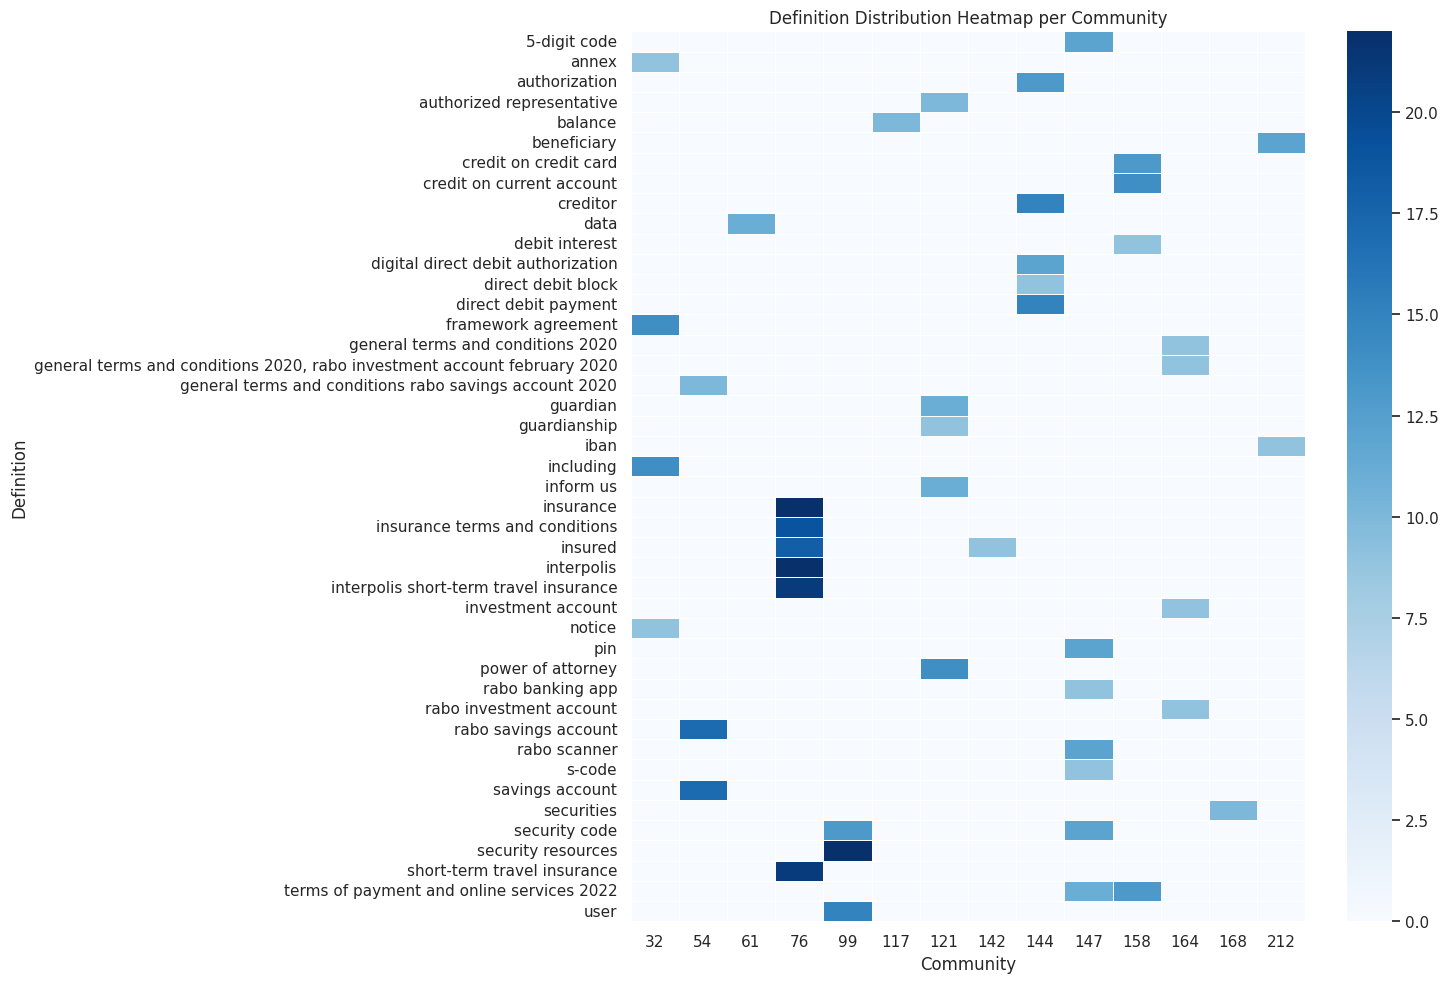

In [64]:
pivot_table = df.pivot(index="definition", columns="leiden_community", values="cnt").fillna(0).sort_index()
sns.set_theme(style="whitegrid")
plt.figure(figsize=(15, 10))
sns.heatmap(pivot_table, cmap="Blues", yticklabels=True, linewidths=0.5)
plt.xlabel("Community")
plt.ylabel("Definition")
plt.title("Definition Distribution Heatmap per Community")
plt.tight_layout()
plt.show()